<a href="https://colab.research.google.com/github/Ulugbek9403/ml_edu/blob/master/notebooks/11_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Регрессия 2 - новые приключения

> 🚀 В этой практике нам понадобятся: `numpy==1.26.4, pandas==2.2.2, matplotlib==3.8.4, scikit-learn==1.4.2`

> 🚀 Установить вы их можете с помощью команды: `%pip install numpy==1.26.4 pandas==2.2.2 matplotlib==3.8.4 scikit-learn==1.4.2`


## Содержание

* [Полиномиальные признаки](#Полиномиальные-признаки)
* [Недообучение (high bias)](#Недообучение-high-bias)
* [Переобучение (high variance)](#Переобучение-high-variance)
* [Из чего состоят данные?](#Из-чего-состоят-данные?)
* [Обратно к проблемам...](#Обратно-к-проблемам...)
* [Train и test выборки](#Train-и-test-выборки)
* [А что, если дать больше данных?](#А-что,-если-дать-больше-данных?)
* [Отношение между сложностью модели и её ошибками (High bias и High Variance)](#Отношение-между-сложностью-модели-и-её-ошибками-High-bias-и-High-Variance)
* [Заключение](#Заключение)
* [Вопросы для закрепления](#Вопросы-для-закрепления)
* [Полезные ссылки](#Полезные-ссылки)


Если вы думали, что на этом история про регрессию закончилась, то вы сильно ошиблись..)

В этом выпуске вы узнаете про магию, обман и другие интересные явления!

И начнём мы с магии! Прошу на борт!

In [1]:
# Настройки для визуализации
# Если используется тёмная тема - лучше текст сделать белым
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
TEXT_COLOR = "black"

plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["text.color"] = TEXT_COLOR
plt.rcParams["font.size"] = 14
plt.rcParams["lines.markersize"] = 15
plt.rcParams["axes.labelcolor"] = TEXT_COLOR
plt.rcParams["xtick.color"] = TEXT_COLOR
plt.rcParams["ytick.color"] = TEXT_COLOR

# Зафиксируем состояние случайных чисел
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

## Полиномиальные признаки

Помните, что любая работа с моделями машинного обучения делается на основе данных?

Так вот, всегда начинаем с анализа данных!

Давайте посмотрим на те данные, которые мы здесь имеем.

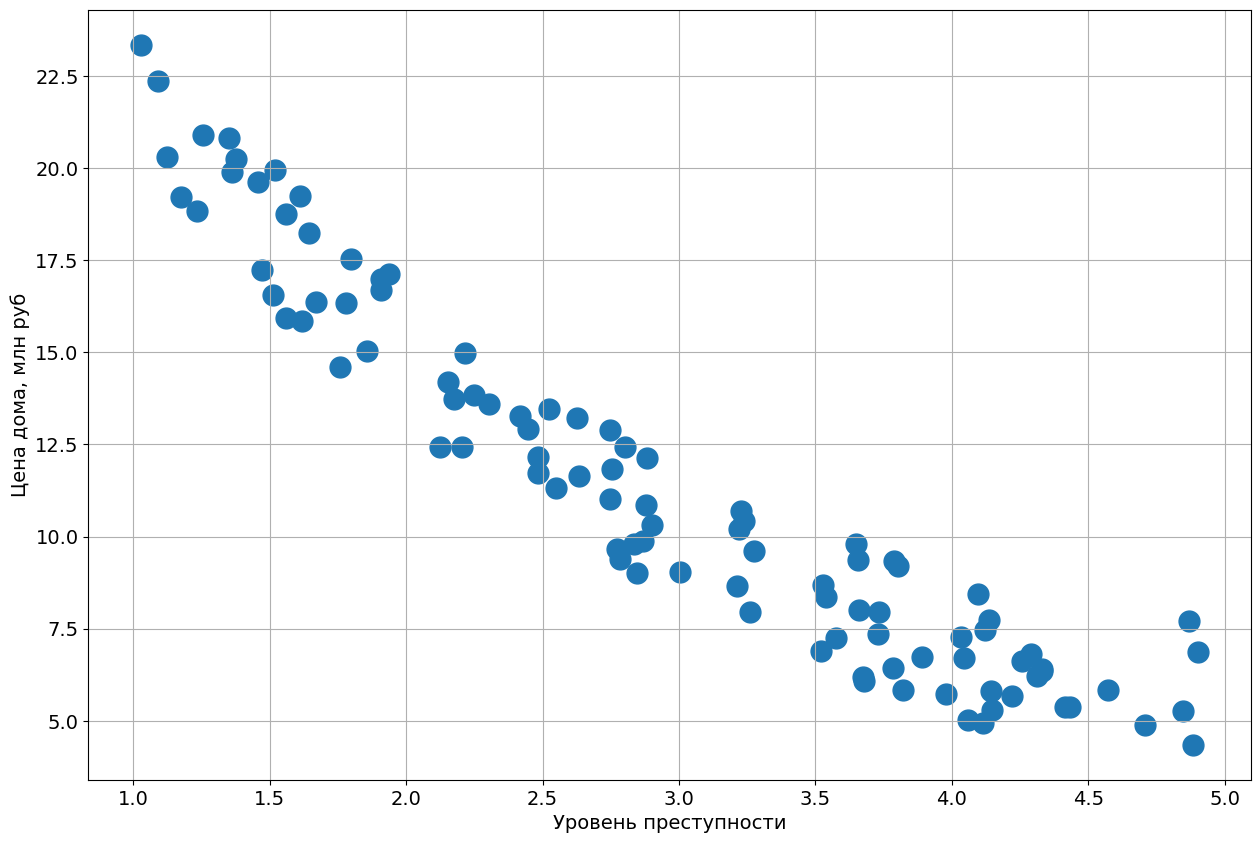

In [2]:
rng = np.random.default_rng(RANDOM_SEED)

# Сгенерируем данные
n_points = 100

_data_shift = 4
_x_data = 4*rng.random(n_points)+1

_x_render = (_x_data-5)
_y_data = _data_shift + 1 *_x_render**2 + rng.random(n_points)*4

df_data = pd.DataFrame({"crime_level": _x_data, "house_price": _y_data})

plt.scatter(_x_data, _y_data)
plt.xlabel("Уровень преступности")
plt.ylabel("Цена дома, млн руб")
plt.grid()
plt.show()

In [3]:
# Также, посмотрим на данные в виде таблицы
df_data.head(5)

,crime_level,house_price
0,4.095824,8.451857
1,2.755514,11.836547
2,4.434392,5.383393
3,3.789472,9.342083
4,1.376709,20.243238


In [4]:
# И размер
df_data.shape

(100, 2)

> ⚠️ Обратите внимание, что даже 100 записей в данных уже усложняет анализ в виде таблицы, при этом визуальное представление всё ещё сохраняет возможность проанализировать данные.

Перво-наперво, мы видим явную зависимость между уровнем преступности и ценами на дома. Это можно использовать и разработать систему предсказания цены дома на основе уровня преступности!

Давайте обратим внимание на то, что зависимость цены дома от уровня преступности имеет явно нелинейный характер - такую зависимость будет невозможно описать линейной моделью. Точнее, описать можно, но точность будет невысокая.

Что в таком случае делать? Давайте вспомним, какие ещё есть варианты аналитических описаний?

<p align="center"><img src="https://raw.githubusercontent.com/AleksDevEdu/ml_edu/master/assets/think_about_it_image.png" width=600></p>

Смотрите, да это же часть параболы!

<p align="center"><img src="https://raw.githubusercontent.com/AleksDevEdu/ml_edu/master/assets/parabola.png" width=600></p>

Общее уравнение параболы выглядит так: $$y = a*x^2+b*x+c$$

А теперь напишем уравнение линейной регрессии для двух переменных: $$y = w_1*x_1+w_2*x_2+w_0$$

Видите связь? По сути, мы можем взять и выразить $x$ как первый признак, $x^2$ как второй признак и таким образом с помощью линейной регрессии решить задачу полиномиальной регрессии!

Если проще - в данных есть $y$ и $x$, но зависимость между ними явно напоминает полиномиальную. Значит немного модифицируем данные, чтобы решить эту сложнейшую задачу!

Так, а как нужно модифицировать данные?

Всё, что нам нужно сделать - это сделать две переменные $x_1$, которая является самой переменной $x$, и $x_2$, которая является квадратом от оригинальной.

Давайте сделаем это в виде функции предобработки данных!

> ⚠️ Ахтунг! Возведение в квадрат может потерять ваш знак, что, например для температуры, может быть неприемлемо.

In [16]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

def preprocess_data(df):
    """
    Функция предобработки данных с генерацией полиномиальных признаков.

    Args:
        df: DataFrame с данными.

    Returns:
        DataFrame с добавленной колонкой "crime_level_poly".
    """


    poly_features = PolynomialFeatures(degree=2)


    crime_level_poly = poly_features.fit_transform(df[['crime_level']])


    df['crime_level_poly'] = crime_level_poly[:, 1]

    return df


df = pd.DataFrame({'crime_level': [1, 2, 3, 4, 5]})


df_processed = preprocess_data(df)


print(df_processed)


   crime_level  crime_level_poly
0            1               1.0
1            2               2.0
2            3               3.0
3            4               4.0
4            5               5.0


In [18]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

def preprocess_data(df):
    """
    Функция предобработки данных с генерацией полиномиальных признаков.

    Args:
        df: DataFrame с данными.

    Returns:
        DataFrame с добавленной колонкой "crime_level_poly".
    """


    poly_features = PolynomialFeatures(degree=2)


    crime_level_poly = poly_features.fit_transform(df[['crime_level']])


    df['crime_level_poly'] = crime_level_poly[:, 1]

    return df


df = pd.DataFrame({'crime_level': [1, 2, 3, 4, 5]})


df_processed = preprocess_data(df)


print(df_processed)


   crime_level  crime_level_poly
0            1               1.0
1            2               2.0
2            3               3.0
3            4               4.0
4            5               5.0


Отлично! А теперь задачка на расширение знаний и умений!

Она не обязательна, но желательна!

Напишите функцию для той же самой генерации фич, но уже с помощью класса из sklearn. Проанализируйте доки класса [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) и напишите с помощью него функцию генерации полиномиальных признаков:

> ⚠️ Это класс трансформера, мы уже сталкивались с моделью, у неё были методы `fit()` и `predict()`. Трансформеры данных преобразуют данные. Они имеют методы `fit()` и `transform()`.

> ⚠️ Обратите внимание, что на вход `transform()` метода должна подаваться матрица признаков. Несмотря на то, что у нас всего вектор признаков, его форму можно поменять с помощью `reshape()`.

In [14]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

def preprocess_data_sklearn(df):
    """
    Функция предобработки данных с генерацией полиномиальных признаков
    с использованием класса PolynomialFeatures.

    Args:
        df: DataFrame с данными.

    Returns:
        DataFrame с добавленной колонкой "crime_level_poly".
    """
    poly_features = PolynomialFeatures(degree=2, include_bias=False)


    poly_features.fit(df[['crime_level']])
    crime_level_poly = poly_features.transform(df[['crime_level']])

    # Добавляем новую колонку
    df['crime_level_poly'] = crime_level_poly[:, 0]

    return df



> 🔥 Думаю, вы заметили, что ручная реализация в данном случае была намного проще. Такие ситуации нередки, поэтому стоит задумываться о том, когда удобно применять готовый функционал, а когда он быстрее и проще реализуется с помощью базовых вызовов.

Превосходно! Мы смогли сгенерировать полиномиальные признаки и, похоже, готовы к обучению модели!

Давайте перейдём к самому вкусному!

In [19]:
from sklearn.linear_model import LinearRegression

df_train_data = df_data.copy()
df_train_data = preprocess_data(df_train_data)

reg_model = LinearRegression()

# Достаем из данных целевую колонку - там остаются только переменные-признаки
y_true = df_train_data.pop("house_price")
# Если в DataFrame остались только признаки, то можно подавать весь фрейм на вход методам классов sklearn
# Так как фрейм - это матрица, то ничего конвертировать не надо
reg_model.fit(df_train_data, y_true)

y_pred = reg_model.predict(df_train_data)

> 🔥 Зачем мы копируем данные в начале ячейки кода? Это сделано специально, чтобы исходные данные не были модифицированы. Другая полезная практика - никогда не вызывать ячейки ноутбука в нелинейном порядке. Как правило, второму нужно учиться и привыкать, когда первое помогает от случайных удалений данных из фреймов сразу.

> 🔥 Есть другая особенность, ноутбуки не удаляют объекты после выполнения ячеек. Таким образом, слишком много копирований может быстро съесть оперативную память, если вы работаете с большими данными (больше 1 ГБ на датафрейм). Обращайте на это внимание!

Обучение прошло, но не забываем, что анализ работы модели - намного более важный процесс, чем само обучение модели!

Для начала визуализируем предсказания нашей модели на графике, чтобы посмотреть, как она пересекается с точками:

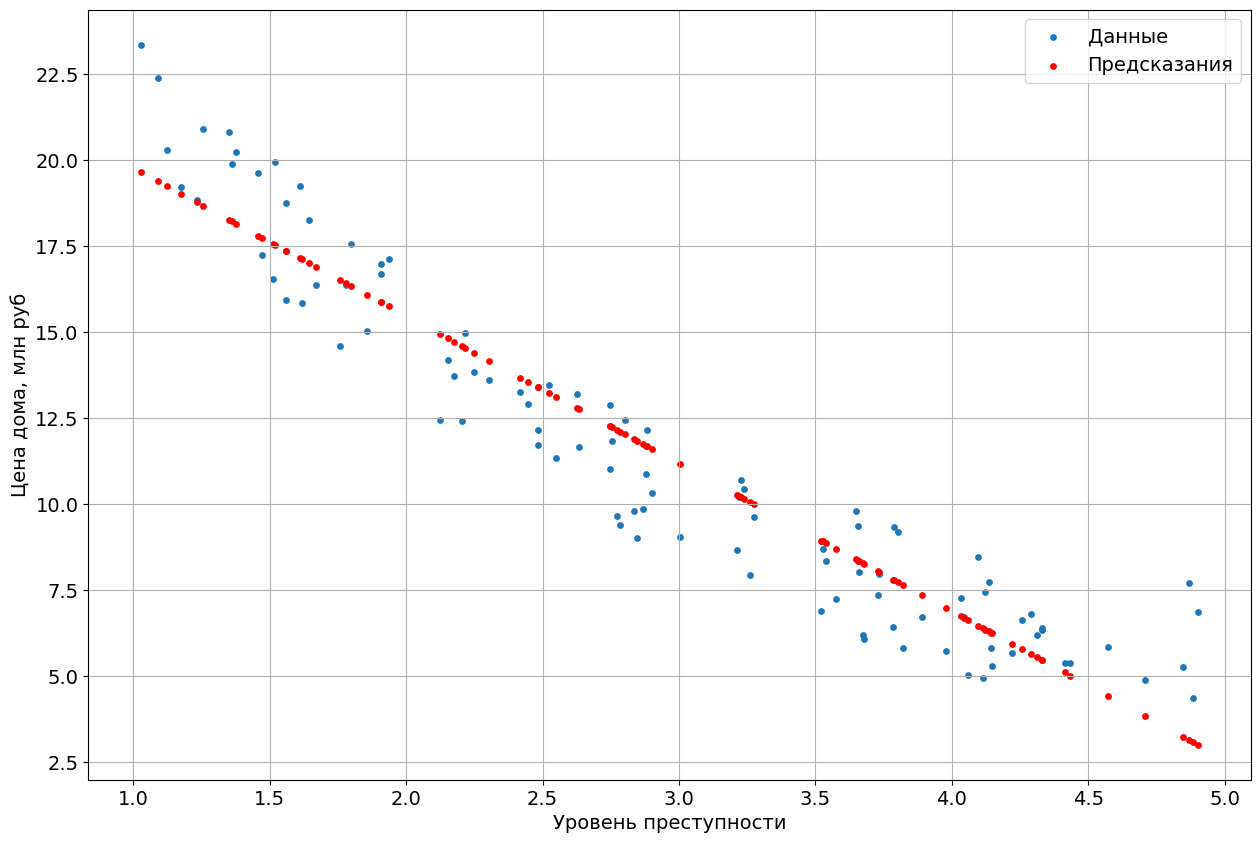

In [20]:
plt.scatter(x="crime_level", y="house_price", data=df_data, s=15, label="Данные")
plt.scatter(df_data["crime_level"], y_pred, c="r", s=15, label="Предсказания")
plt.xlabel("Уровень преступности")
plt.ylabel("Цена дома, млн руб")
plt.grid()
plt.legend()
plt.show()

По графику видно, что модель проходит через точки, что делает первую проверку пройденной, модель действительно восстановила зависимость данных.

Это означает, что мы научились применять специальную предобработку данных, когда в данных видна явная полиномиальная зависимость для реализации полиномиальной регресии. Шикарно!

## Недообучение (high bias)

В ходе работы с данными и обучением моделей вы столкнётесь с разными интересными эффектами. Сейчас наш арсенал состоит только из линейной и полиномиальной регресий (вторая - частный случай первой), но тем не менее мы уже можем рассмотреть интересный эффект, который возникает при обучении.

Давайте вспомним, что линейная регрессия может описывать зависимости вида прямой линии под разными углами наклона.

Полиномиальная второго порядка (степень второго порядка) может описывать параболические зависимости.

Третий порядок сможет описать более сложные и гибкие (хитрые) зависимости в данных.

То есть, степень полинома можно рассматривать как сложность модели - чем больше степень, тем более сложные зависимости можно описать.

> ⚠️ То есть в задаче регрессии степень полиномиальных признаков = сложность модели.

В ходе работы с одним признаком мы смогли нарисовать график, который визуализирует зависимость целевой переменной от признака (фичи), но в работе могут быть данные, в которых есть множество признаков! Визуализировать всё сразу не получится.

> ⚠️ Тем не менее, полезно визуализировать графики в осях "целевая переменная" - "признак" для оценки влияния признака на целевую переменную.

Давайте посмотрим на другие данные, в которых выражена сильная нелинейность:

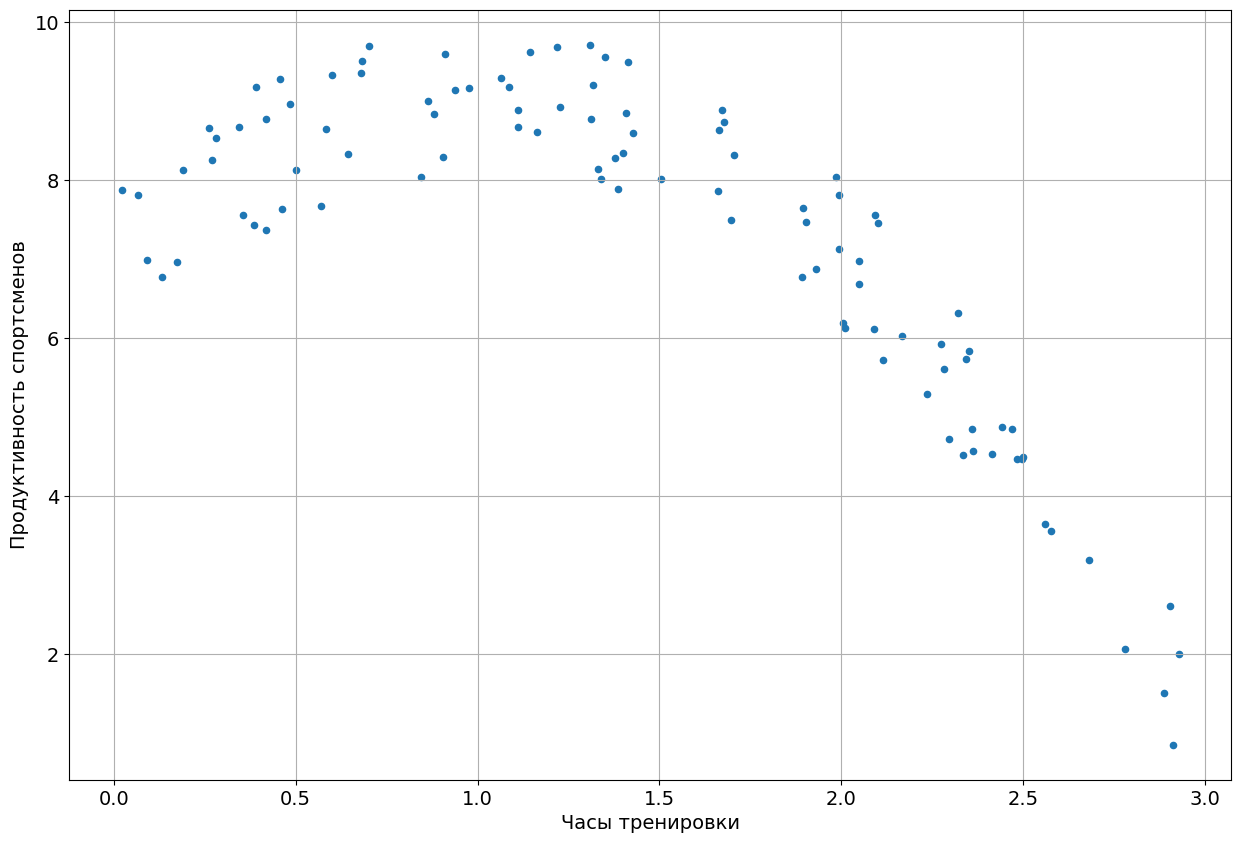

In [21]:
rng = np.random.default_rng(RANDOM_SEED)

_x_data = 3*rng.random(100)
_y_data = 7 + 4*_x_data + -2*_x_data**2 + 2*(rng.random(_x_data.shape[0])-0.5)

df_data = pd.DataFrame({"hours": _x_data, "productivity": _y_data})

plt.scatter(x="hours", y="productivity", data=df_data, s=20)
plt.xlabel("Часы тренировки")
plt.ylabel("Продуктивность спортсменов")
plt.grid()
plt.show()

In [22]:
df_data.head()

,hours,productivity
0,2.321868,6.322491
1,1.316635,9.198898
2,2.575794,3.565488
3,2.092104,7.552970
4,0.282532,8.527981


In [23]:
df_data.shape

(100, 2)

Данные представляют собой зависимость продуктивности спортсменов в разрезе часов тренировки.

Видна сильная нелинейная зависимость, но при этом давайте попробуем обучить явно "слабую" модель, которая постарается описать это линейной зависимость.

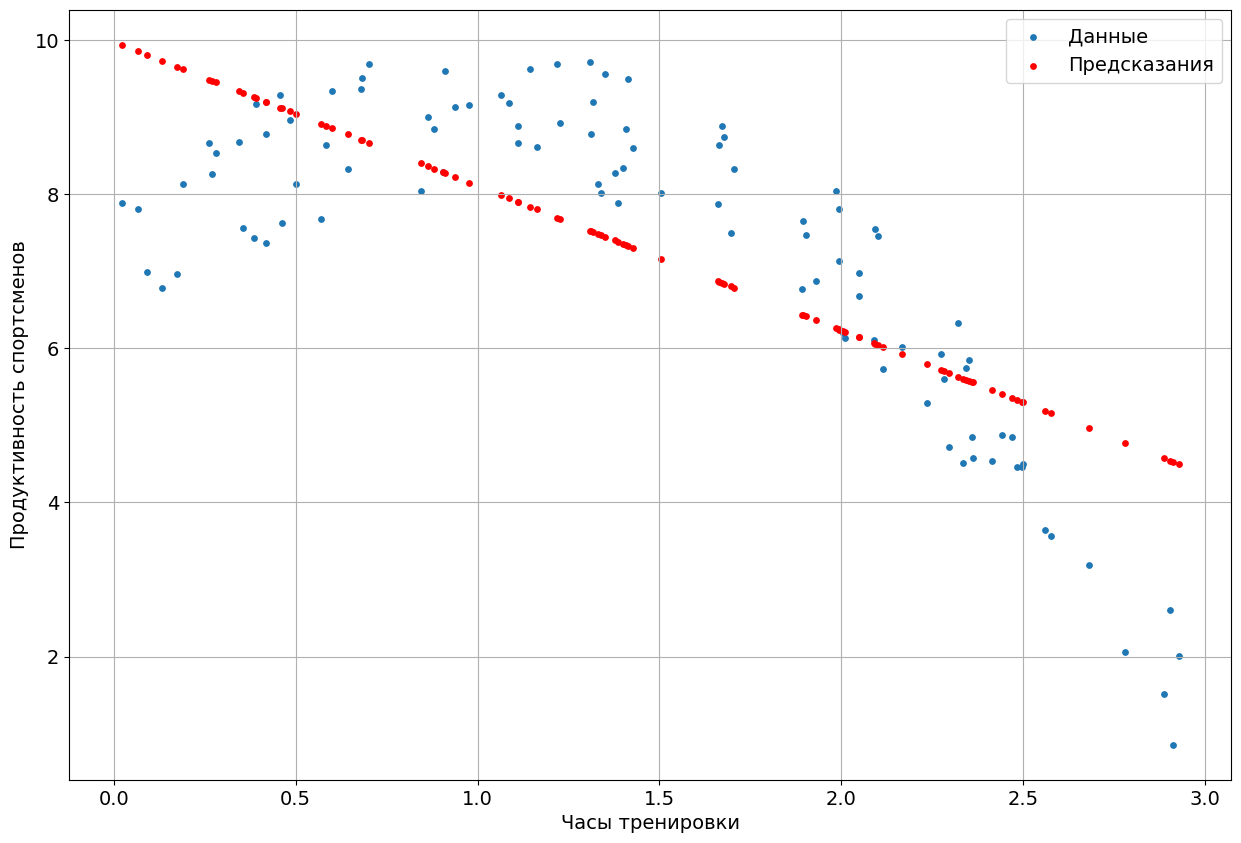

In [24]:
df_train_data = df_data.copy()
reg_model = LinearRegression()

y_true = df_train_data.pop("productivity")
reg_model.fit(df_train_data, y_true)

y_pred = reg_model.predict(df_train_data)

plt.scatter(x="hours", y="productivity", data=df_data, s=15, label="Данные")
plt.scatter(df_data["hours"], y_pred, c="r", s=15, label="Предсказания")
plt.xlabel("Часы тренировки")
plt.ylabel("Продуктивность спортсменов")
plt.grid()
plt.legend()
plt.show()

На графике видно, что модель в виде прямой линии проходит через точки, то есть обучение прошло и модель даже описывает базовую тенденцию, но тип зависимости не тот, который есть в данных. Особенно выделяется часть с часами до 1.0, так как на том участке зависимость росла.

Тогда нам нужно подкрепить нашу визуальную оценку количественными показателями, но как это сделать?

Мы познакомились с MAE, который хорош, если мы оцениваем несколько вариантов моделей, так как единичное измерение трудно интерпретировать. Мы можем явно взять полиномиальную модель и на ней видеть, что MAE возросло. Что же делать...?

> ⚠️ Важно обратить внимание, что хоть мы сейчас и рисуем графики, при наличии множества признаков невозможно (без хитрого инструментария) визуализировать предсказания в плоскости для сравнения с данными.

Вот бы был такой показатель, который отражает "хорошесть" обученой модели без необходимости сравнения...

В задаче регрессии есть метрика под названием $R^2$ (r-squared) - коэффициент детерминации, который имеет две особенности:
- имеет верхний предел 1.0, что позволяет судить об оценке без сравнений
- хоть и не имеет нижнего предела, но значения менее 0 говорят о том, что модель описывает данные хуже, чем если просто взять среднее от данных и всегда его предсказывать.

Вроде звучит вкусно!

---

Если кому интересно, можете пройтись по математике и выполнить задачку

Вычисляется оценка с помощью двух составляющих:

- Сумма квадратов отклонений данных (total sum of squares)
$$
SS_{tot}=\sum_{i}(y^{(i)}-\bar{y})^2
$$

- Сумма отклонений предсказаний (sum of squares of residuals)
$$
SS_{res}=\sum_{i}(y^{(i)}-h_W^{(i)}(x^{(i)}))^2
$$

где $\bar{y}=\frac{1}{n}\sum_{i}y^{(i)}$

Сама оценка рассчитывается следующим образом:
$$
R^2=1-\frac{SS_{res}}{SS_{tot}}
$$

Доки функции [r2_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)

In [26]:
import numpy as np
from sklearn.metrics import r2_score

def r2_score_manual(y_true, y_pred):
    """
    Функция для ручного расчета коэффициента детерминации (R-квадрат).

    Args:
        y_true: Массив истинных значений.
        y_pred: Массив предсказанных значений.

    Returns:
        Значение R-квадрат.
    """
    y_mean = np.mean(y_true)
    SS_tot = np.sum((y_true - y_mean)*2)
    SS_res = np.sum((y_true - y_pred)*2)
    r2_value = 1 - (SS_res / SS_tot)
    return r2_value

y_true = np.array([1, 2, 3, 4, 5])
y_pred = np.array([1.1, 2.2, 2.9, 4.1, 5.3])

r2_manual = r2_score_manual(y_true, y_pred)
r2_sklearn = r2_score(y_true, y_pred)

print(f"R-квадрат (ручной расчет): {r2_manual:.4f}")
print(f"R-квадрат (sklearn): {r2_sklearn:.4f}")


def r2_score_manual(y_true, y_pred):
    return r2_value

R-квадрат (ручной расчет): inf
R-квадрат (sklearn): 0.9840


<ipython-input-26-86639235e4b8>:18: RuntimeWarning: divide by zero encountered in scalar divide
  r2_value = 1 - (SS_res / SS_tot)


Если вы выполнили задачу, то вы уже увидели значение коэффициента детерминации.

Если нет, то давайте посмотрим на него с другой стороны.

Класс `LinearRegression` имеет метод `.score()`, которому можно передать данные для оценки и по умолчанию он вернёт значение $R^2$:

In [55]:
r2_value
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

RANDOM_SEED = 42

# Генерация данных
rng = np.random.default_rng(RANDOM_SEED)
_x_data = 3*rng.random(2000)
_y_data = 7 + 4*_x_data + -2*_x_data*2 + 2*(rng.random(_x_data.shape[0])-0.5)

df_data_large = pd.DataFrame({"hours": _x_data, "productivity": _y_data})

# Разделение данных на обучение и тестирование
X_train, X_test, y_train, y_test = train_test_split(df_data_large[['hours']], df_data_large['productivity'], test_size=0.2, random_state=RANDOM_SEED)

# Предобработка с полиномиальными признаками 15-й степени
poly_features = PolynomialFeatures(degree=15, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# Обучение модели
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Предсказания на тестовой выборке
y_test_pred = model.predict(X_test_poly)

# Истинные значения тестовой выборки
y_test_true = y_test

# Вычисление R-squared
r2_value = model.score(X_test_poly, y_test_true)

print(f"y_test_pred: {y_test_pred[:5]}")
print(f"y_test_true: {y_test_true[:5]}")
print(f"R-squared: {r2_value:.4f}")



y_test_pred: [6.95020222 6.96048016 6.93193803 6.97151569 6.96558789]
y_test_true: 1860    6.939931
353     7.096547
1333    6.485348
905     7.297550
1289    6.866748
Name: productivity, dtype: float64
R-squared: -0.0168


Ого, но что это значит? =)

* Показатель $R^2$ выше нуля говорит о том, что модель работает лучше, чем если бы мы взяли среднее от целевой переменной и его постоянно предсказывали (константная модель).

* Значение близкое к 0.5 является достаточно низким

* Показатели на уровне 0.8-0.9 уже являются более приемлемыми, но это не говорит о том, что на уровне 0.55 модель никуда не годится.

> ⚠️ Даже у тех метрик, у которых определены пределы, никогда нельзя закладываться на конкретные ожидаемые числа. Чем больше/меньше (в зависимости от показателя), тем лучше, но многое зависит от данных. Часто бывает так, что даже самая сложная модель на очень плохих данных даёт низкие показатели.

Так мы выявили численно без необходимости сравнения, что модель плохо описывает данные. График ранее подтверждает это. В этом и проявляется эффект **недообучения (high bias, underfit)**.

> 🤓 Недообучение (underfit, high bias) - эффект, при котором модель не может восстановить зависимость. Как правило возникает из-за того, что модель недостаточно сложная или данные имеют неадекватно сложные зависимости внутри (низкое качество в данных, много ошибок в разметке).

Таким образом, по показателю $R^2$ и, если возможно, визуализации предсказаний можно понять, что модель имеет недостаточную сложность, и нужно сменить тип модели или сделать её сложнее (в случае линейной регресии добавить полиномиальных признаков).

Отличный результат! Вот ещё один инструмент анализа в копилку!

## Переобучение (high variance)

На этом наше приключение в лесу забавных и не очень эффектов обучения моделей не заканчивается!

Если до этого **недообучение**, которое не так сложно поддается анализу, является цветочками 🌺, то сейчас мы углубимся в один из наиболее неприятных и опасных эффектов в обучении - **переобучение**.

А ещё мы поймём, почему до этого мы жутко читерили и так никогда делать больше не будем!

Начнем, как всегда, с набора данных:

In [ ]:
rng = np.random.default_rng(RANDOM_SEED)

_x_data = 3*rng.random(20)
_y_data = 7 + 4*_x_data + -2*_x_data**2 + 2*(rng.random(_x_data.shape[0])-0.5)

df_data = pd.DataFrame({"hours": _x_data, "productivity": _y_data})

plt.scatter(x="hours", y="productivity", data=df_data, s=20)
plt.xlabel("Часы тренировки")
plt.ylabel("Продуктивность спортсменов")
plt.grid()
plt.show()

In [34]:
df_data.shape

(100, 2)

In [35]:
df_data.head(5)

,hours,productivity
0,2.321868,6.322491
1,1.316635,9.198898
2,2.575794,3.565488
3,2.092104,7.552970
4,0.282532,8.527981


Воспользуемся теми же самыми данными, но уменьшим выборку до 20 примеров.

Помимо этого, давайте представим, что мы поняли, что линейная модель здесь на работает и мы решили бахнуть 15-ю степень!

Давайте напишем функцию предобработки:

In [36]:
import pandas as pd

def preprocess_data_high_poly(df, degree):
  """
  Функция предобработки данных с генерацией полиномиальных признаков.

  Args:
      df: DataFrame с данными.
      degree: Степень полинома.

  Returns:
      DataFrame с новой колонкой hours_poly_n.
  """
  df['hours_poly_' + str(degree)] = df['hours'] * degree
  return df

data = {'hours': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}
df = pd.DataFrame(data)

df = preprocess_data_high_poly(df, 15)

print(df)


    hours  hours_poly_15
0       1             15
1       2             30
2       3             45
3       4             60
4       5             75
5       6             90
6       7            105
7       8            120
8       9            135
9      10            150
10     11            165
11     12            180
12     13            195
13     14            210
14     15            225
15     16            240
16     17            255
17     18            270
18     19            285
19     20            300


In [38]:
# TEST - проверимс ваше решение
import pandas as pd

def preprocess_data_high_poly(df, degree):
  """
  Функция предобработки данных с генерацией полиномиальных признаков.

  Args:
      df: DataFrame с данными.
      degree: Степень полинома.

  Returns:
      DataFrame с новой колонкой hours_poly_n.
  """
  df['hours_poly_' + str(degree)] = df['hours'] * degree
  return df

# Загрузка данных
data = {'hours': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}
df = pd.DataFrame(data)

# Предобработка данных с 15-й степенью полинома
df = preprocess_data_high_poly(df, 15)

print(df)


    hours  hours_poly_15
0       1             15
1       2             30
2       3             45
3       4             60
4       5             75
5       6             90
6       7            105
7       8            120
8       9            135
9      10            150
10     11            165
11     12            180
12     13            195
13     14            210
14     15            225
15     16            240
16     17            255
17     18            270
18     19            285
19     20            300


А теперь обучим модель и посмотрим на график зависимости, которую мы попытались восстановить:

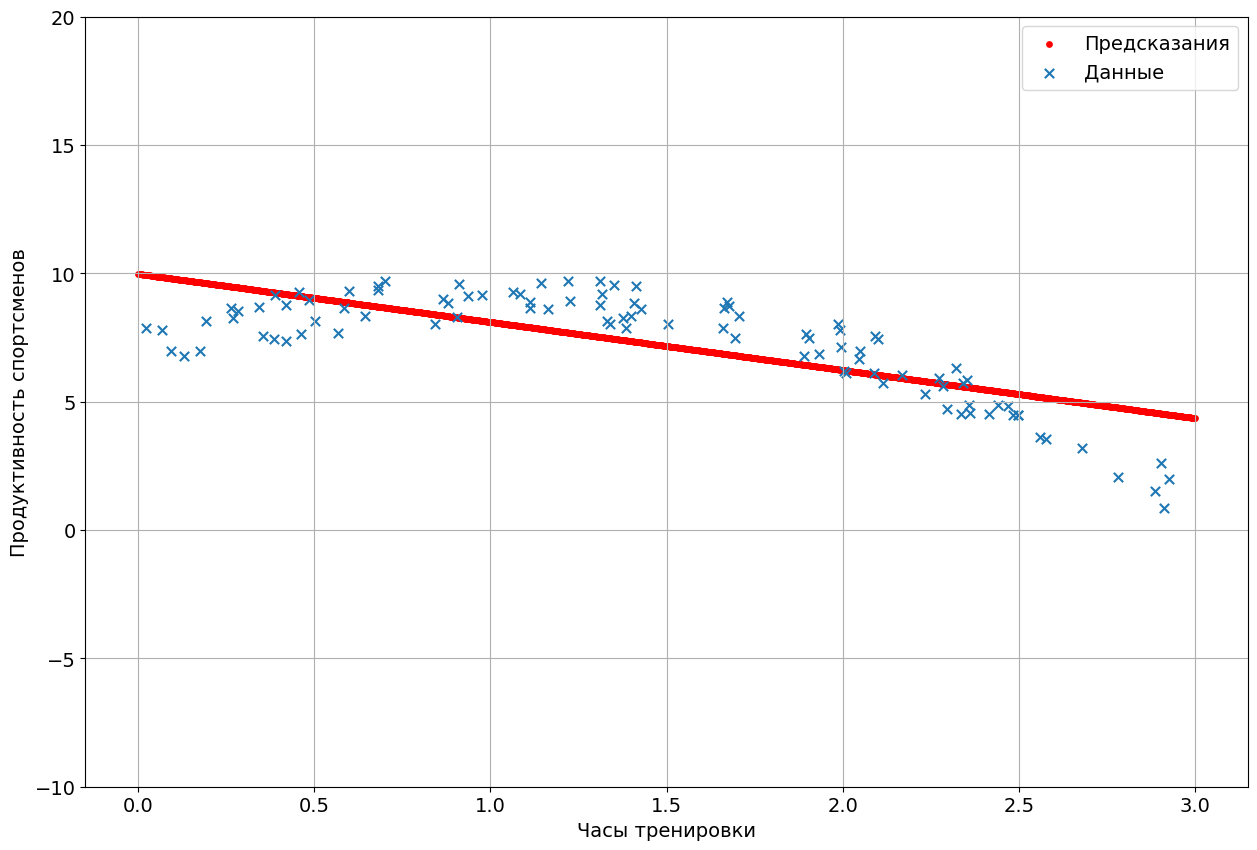

In [40]:
df_train_data = df_data.copy()
reg_model = LinearRegression()

df_train_data = preprocess_data_high_poly(df_train_data, 15)

y_true = df_train_data.pop("productivity")
reg_model.fit(df_train_data, y_true)

y_pred = reg_model.predict(df_train_data)

x_render = np.linspace(0, 3, 1000)
df_check_data = pd.DataFrame({"hours": x_render})

df_check_data = preprocess_data_high_poly(df_check_data, 15)
y_pred_render = reg_model.predict(df_check_data)

plt.scatter(x_render, y_pred_render, c="r", s=15, label="Предсказания")
plt.scatter(x="hours", y="productivity", data=df_data, marker="x", s=45, label="Данные")
plt.xlabel("Часы тренировки")
plt.ylabel("Продуктивность спортсменов")
plt.ylim([-10, 20])
plt.grid()
plt.legend()
plt.show()

Что же это за чудовище?? Что случилось? Где-то ошибка?

Не пугаемся, просто случилось то, чего боятся все, кто работает в области машинного обучения - ОВЕРФИТ (Overfit)!

Что это значит? Да именно то, что модель не выявила зависимость. Она в данных намного проще, чем модель построила!

В данном случае модель перешла за границу построения общей зависимости и начала реагировать на **шум в данных** и подстраиваться под него!

Шум? Какой шум? Что ещё за шум??

Давайте немного отклонимся и поговорим из чего состоят все данные!

## Из чего состоят данные?

Я вам открою маленькую тайну, эти данные сгенерированы, только тссс.. :bowtie:

Так вот, давайте посмотрим на реальную зависимость, по которой эти данные построены:

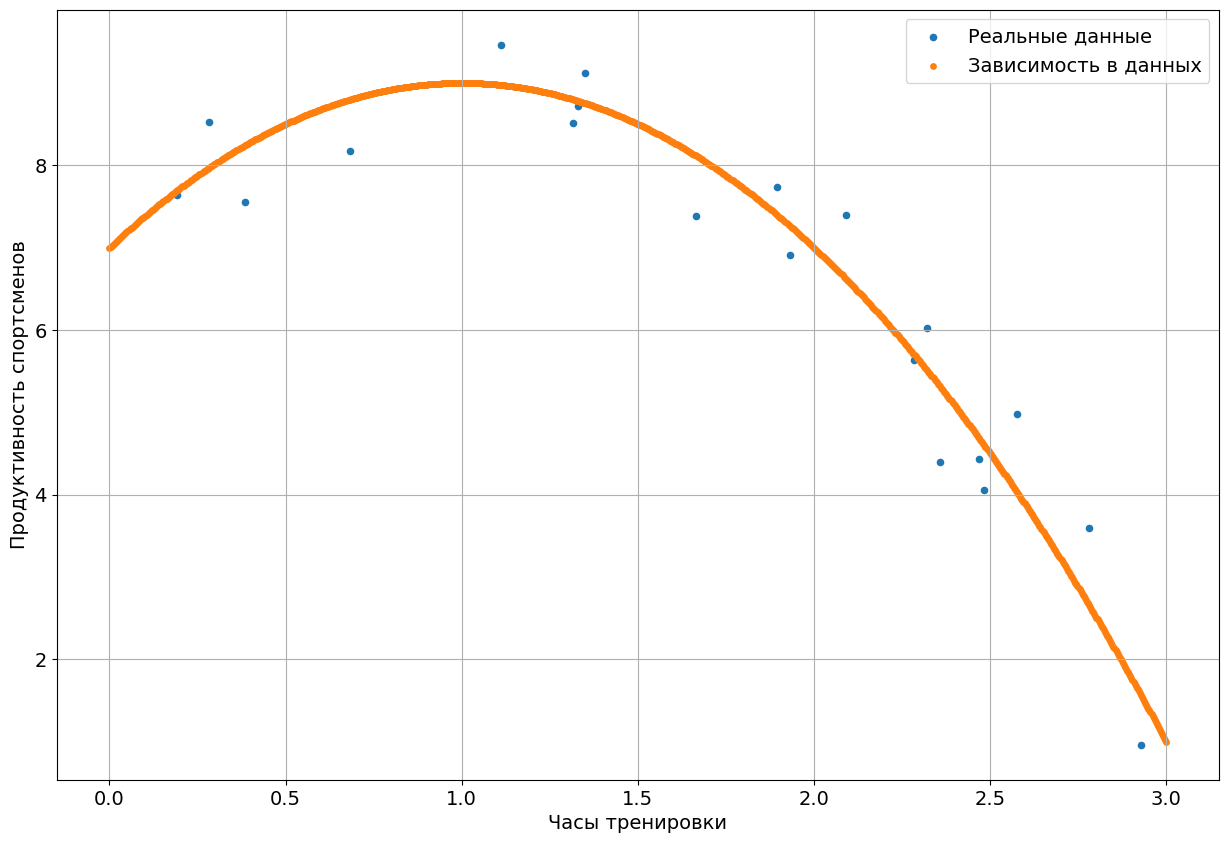

In [41]:
rng = np.random.default_rng(RANDOM_SEED)

_x_sample_data = 3*rng.random(20)
_y_sample_data = 7 + 4*_x_sample_data + -2*_x_sample_data**2 + 2*(rng.random(_x_sample_data.shape[0])-0.5)

_x_line_data = np.linspace(0, 3, 1000)
_y_line_data = 7 + 4*_x_line_data + -2*_x_line_data**2

plt.scatter(_x_sample_data, _y_sample_data, s=20, label="Реальные данные")
plt.scatter(_x_line_data, _y_line_data, s=15, label="Зависимость в данных")
plt.xlabel("Часы тренировки")
plt.ylabel("Продуктивность спортсменов")
plt.legend()
plt.grid()

Смотрите, на графике линией отражена зависимость без примесей, т.е. истинная зависимость. Это часть параболы, то есть полином второй степени. Но данные (точки) не лежат на самой линии. Почему?

Да всё потому что, любые данные состоят из двух основных составляющих: $$данные = шум + зависимости$$

То есть, шум есть в любых данных! Он может варьироваться по величине, характеру, но главное, что это то, что он отвлекает нас от главного в данных - зависимостей, которые мы пытаемся понять, достать и использовать!

Откуда он берётся?

Всё просто, если данные - это замеры времени круга бегуна, то это могут быть неточности измерения человеком на секундомере. Если это данные по скорости движения автомобиля на трассе, то датчик может иметь погрешность. Причин может быть много, но главное, что шум есть всегда!

> ⚠️ Ещё раз, шум в данных присутсвует всегда. Если у вас данные лежат на прямой или ровно по линии - повод их перепроверить!

Что с этим делать? Тщательнее проверять работу модели, к чему предлагаем и вернуться!

## Обратно к проблемам...

Ещё раз посмотрим на график

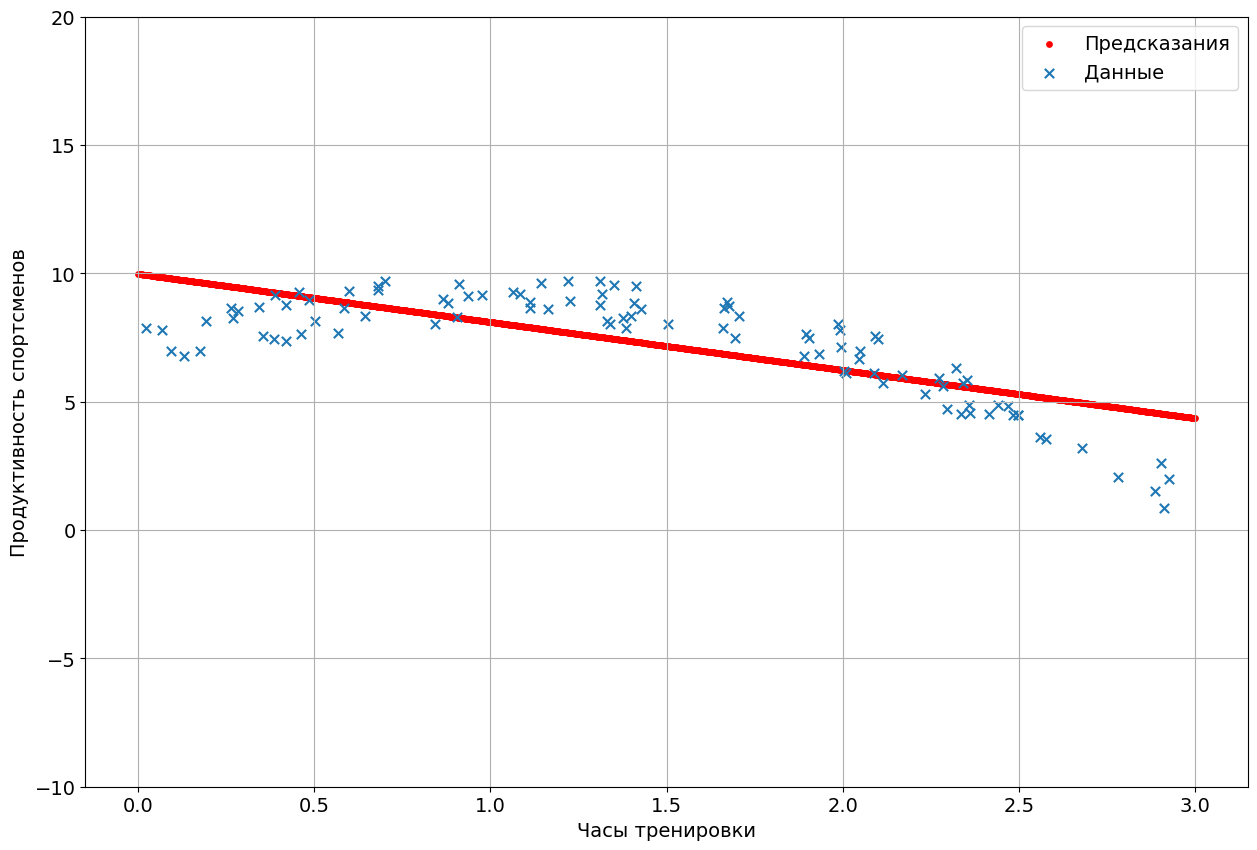

In [42]:
plt.scatter(x_render, y_pred_render, c="r", s=15, label="Предсказания")
plt.scatter(x="hours", y="productivity", data=df_data, marker="x", s=45, label="Данные")
plt.xlabel("Часы тренировки")
plt.ylabel("Продуктивность спортсменов")
plt.ylim([-10, 20])
plt.grid()
plt.legend()
plt.show()

Уфф, лучше не стало, но понадеяться стоило =)

Так вот, что же с этим делать? Как помним, визуализация нам не всегда доступна, поэтому считаем, что нам сейчас повезло, но что делать, если её нет?

Вот бы коэффициент, которые показывает, насколько модель хорошо отражает данные - $R^2$, кажется. Давайте попробуем!

In [43]:
from sklearn.metrics import r2_score

r2_value = r2_score(y_true, y_pred)

r2_value

0.5587425113942917

Огооо, больше 0.95, да эта модель знает данные лучше, чем кто-либо! Похоже, так не выйдет..

Ладно, давай проверим показатель ошибок, вдруг он будет заоблачным?

In [44]:
from sklearn.metrics import mean_absolute_error

mae_value = mean_absolute_error(y_true, y_pred)

mae_value

1.1264981359298512

Да что такое, меньше 0.2 (2х процентов от максимума = 10 единиц). Тоже ничего такого, как же быть?

Есть один способ, но давайте для начала подумаем...

<p align="center"><img src="https://raw.githubusercontent.com/AleksDevEdu/ml_edu/master/assets/think_about_it_image.png" width=600/></p>

## Train и test выборки

Не хотел я вам признаваться, но всё это время мы делали одну очень серьезную ошибку в машинном обучении.

В подходе машинного обучения есть понятие разделения данных на выборки. Самое простое разделение называется **train-test split**, что означает "разделение данных на выборки обучения и тестирования".

Для чего это делается?

Очень просто! Представьте, что вы учитесь играть в футбол. У вас есть команда, с которой вы тренируетесь, постоянно играете, отрабатываете удары, защиту, нападение и т.д. И все тренировки проходят +/- в одной и той же среде. И вот настаёт время соревнований (оценки ваших способностей). Соревнования серьёзные, поэтому они проходят в другом городе, собираются разные команды, со всего мира!

И вот начинается оценка ваших способностей: если вы хорошо тренировались, учили комбинации, как надо постигали техники, то даже в новой среде и игре против новой команды вы всё равно сможете выстоять против соперников! Это хороший результат обучения.

А теперь представьте другой вариант, вы запомнили все привычки ваших друзей, с кем тренировались. Выучили их движения и с легкостью их обыгрываете. Но пусть на поле против вас выйдет другая команда - вы уже не сможете их обыграть =(

Почему так происходит? Потому что как в футболе, так и в обучении модели, необходимо выявлять общие зависимости в данных, движении, поведении. Если просто запомнить то, что вам даётся для обучения (например, что у Васи больная левая коленка, и его можно обыграть слева), то оценка на новых данных будет сильно смещена!

Аналогично при работе с данными мы делаем просто финт: разделяем данные на выборки так, чтобы были данные, на которых мы учимся играть, и данные для оценки способностей в игре.

Как правило, тренировочных часов в футболе явно больше, чем соревновательных, поэтому и выборки часто делают в отношении 80 к 20 или 70 к 30.

> ⚠️ Как выбрать соотношение? В статистике есть понятие репрезентативности. Если мы имеем набор данных из 1000 примеров, то лучше выделить на тест 300 примеров, чтобы тестирование модели было адекватным. А вот если мы имеем 1 000 000, то тут уже можно выделить и 20% от основного набора или даже 10%, так как выборка для тестирования будет достаточно репрезентативна. Правило простое, лучше не жалеть в выборке на тест, так как лучше тестирование будет более адекватным и покажет хуже результаты, чем мы не заметим в модели негативные эффекты!

Хватит слов - пора вернуться к нашей проблеме и решить её!

Давайте воспользуемся готовой функцией sklearn - [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), чтобы изначально разделить наши данные:

In [45]:
from sklearn.model_selection import train_test_split
df_train_data, df_test_data = train_test_split(df_data, test_size=.3, random_state=RANDOM_SEED, shuffle=True)

df_train_data.shape, df_test_data.shape

((70, 2), (30, 2))

Отлично, в наших данных 14 примеров для обучения и 6 для тестирования!

> 🔥 Всегда фиксируйте `random_state` в функциях, если это возможно. На этом строится понятие **воспроизводимости экспериментов**. То есть, если эксперимент, который вы проводили, нельзя воспроизвести, то это очень плохо, так как результаты могут сильно колебаться. Погуглите, на сегодняшний день этот вопрос очень актуален в кругах data science инженеров.

Давайте посмотрим, как они разделены между собой:

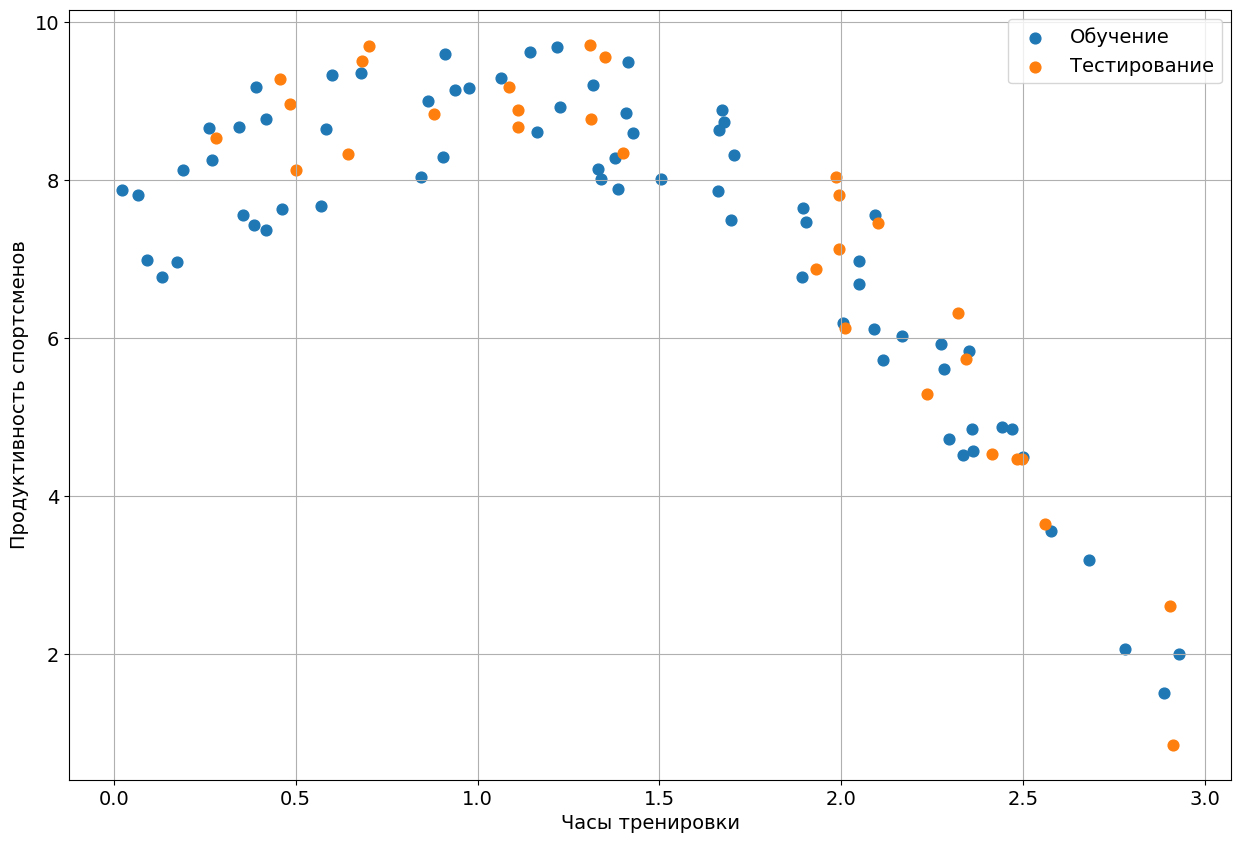

In [46]:
plt.scatter(x="hours", y="productivity", data=df_train_data, s=60, label="Обучение")
plt.scatter(x="hours", y="productivity", data=df_test_data, s=60, label="Тестирование")
plt.xlabel("Часы тренировки")
plt.ylabel("Продуктивность спортсменов")
plt.grid()
plt.legend()
plt.show()

Отлично, мы видим, что тестовые данные есть и в начале, и в середине диапазона и в конце. Почему это важно?

Ответ также прост, если мы будем обучать на выборке до 1.5 часов тренировки, а тестировать на выборке более 1.5 часов, то нелогично ожидать от модели способности адекватно предсказывать на данных для тестирования. Она же подобные данные никогда не видела и не знает, какие там зависимости.

> ⚠️ Всегда старайтесь логически подходить к процессу обучения модели. Модель не сделает больше заложенного, поэтому и результаты как правило ожидаемы, если учесть большинство факторов.

Именно по этой причине мы сделали `shuffle=True` в вызове функции разделения. Это для того, чтобы перемешать выборку и выбирать случайно примеры для обучения и теста. Тогда высока верятность, что в тест попадут примеры, пересекающиеся по области из выборки для обучения!

> ⚠️ На этом основано понятие **домен данных**. Если домен данных для тестирования отличается от домена выборки для обучения, то это очень плохо.

> ⚠️ Другой полезный термин - **дрифт данных**, аналогично, если модель обучалась на одних данных (до 2-х часов тренировки), а в ходе реальной работы модели стали поступать данные о 3-х и 4-х часах тренировки для предсказания, то это смещение и должно быть отслежено. Не то, чтобы это было легко сделать..

Когда данные разделены - переходим к процессу обучения!

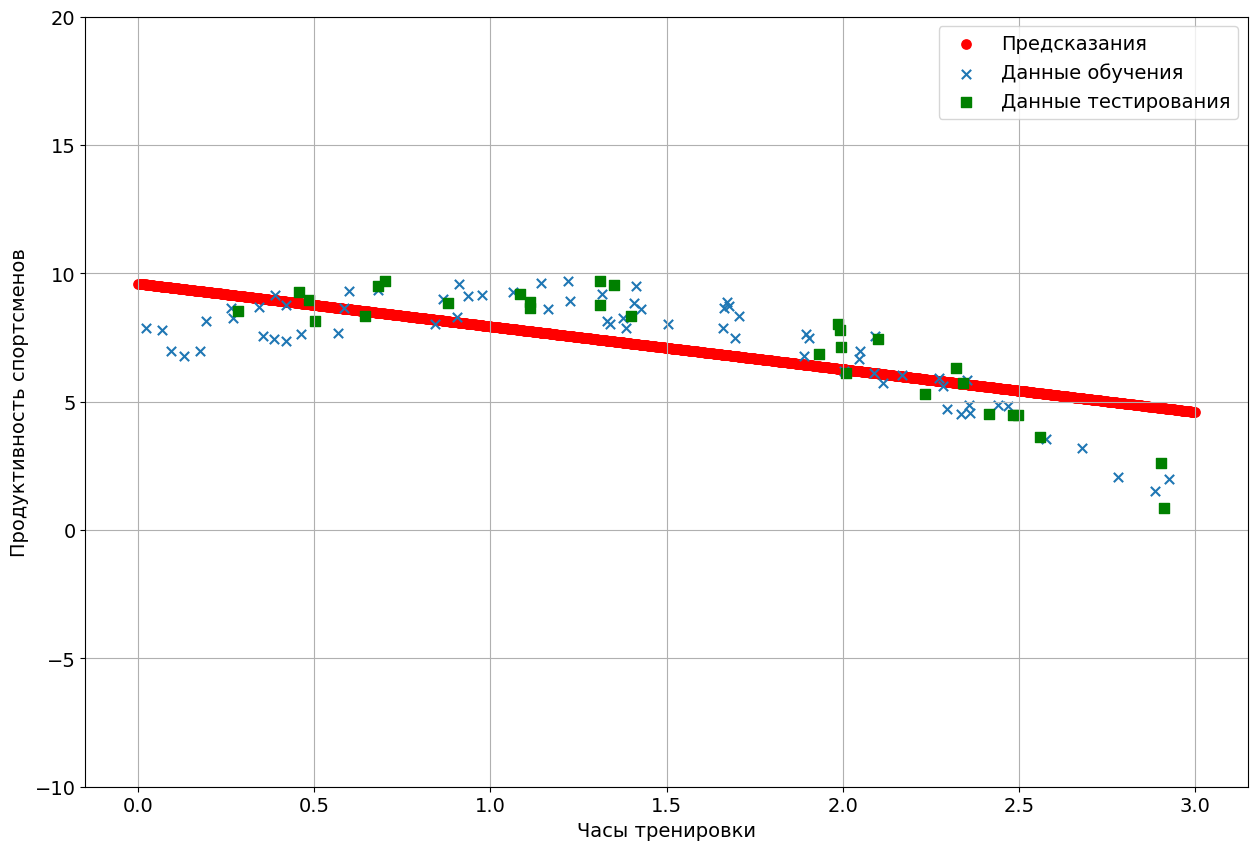

In [48]:
reg_model = LinearRegression()

df_x = df_train_data.copy()
df_x = preprocess_data_high_poly(df_x, 15)

y_true = df_x.pop("productivity")
reg_model.fit(df_x, y_true)

y_pred = reg_model.predict(df_x)

x_render = np.linspace(0, 3, 1000)
x_render = np.concatenate([x_render, df_x["hours"]])
df_line_data = pd.DataFrame({"hours": x_render})

df_line_data = preprocess_data_high_poly(df_line_data, 15)
y_pred_render = reg_model.predict(df_line_data)

plt.scatter(x_render, y_pred_render, c="r", s=45, label="Предсказания")
plt.scatter(x="hours", y="productivity", data=df_train_data, marker="x", s=45, label="Данные обучения")
plt.scatter(x="hours", y="productivity", data=df_test_data, c="g", marker="s", s=45, label="Данные тестирования")
plt.xlabel("Часы тренировки")
plt.ylabel("Продуктивность спортсменов")
plt.ylim([-10, 20])
plt.grid()
plt.legend()
plt.show()

А теперь самое вкусное - сравним показатели ошибок на выборке обучения и тестирования:

In [49]:
df_test_x = df_test_data.copy()
df_test_x = preprocess_data_high_poly(df_test_x, 15)

y_test_true = df_test_x.pop("productivity")

y_test_pred = reg_model.predict(df_test_x)

mae_value_train = mean_absolute_error(y_true, y_pred)
mae_value_test = mean_absolute_error(y_test_true, y_test_pred)

print(f"Test vs train: {mae_value_test} | {mae_value_train}")
print(f"Error ratio: {mae_value_test/mae_value_train}")

Test vs train: 1.1173878389350114 | 1.148468511435708
Error ratio: 0.9729372880569076


А вот и индикатор переобучения!

Сами видите, ошибка теста почти в 20 миллионов раз выше, чем ошибка обучения. Так мы сразу понимаем, что мы перебрали со сложностью модели и произошло переобучение!

> 🤓 Переобучение (overfit, high variance) - эффект, который возникает при сильном превышении сложности модели над сложностью зависимости в данных. Чаще всего появляется из-за малого количества данных или слишком сложной модели.

> ⚠️ Отныне перед работой с данными важно разделять данные на обучение и тестирование (как минимум). В дальнейшем мы узнаем про другие типы выборок, но сейчас важно запомнить именно это. **Тестовая выборка** - это на новый год, поэтому ее откладывают до последнего момента оценки работы с моделью. Она считается эталонной, чтобы понять, как модель будет работать с данными, которые ещё не видела, но при этом имеет разметку (истинные значения), что позволяет сделать оценку.

Таким образом, мы научились определять переобучение в данных и делать это очень неплохо!

Отныне мы будем всегда разделять данные, чтобы у нас была возможность проверить адекватность модели, иначе вот так обрадуемся шикарным показателям на выборке для обучения и никак не проверим адекватность модели =(

> 🔥 В применении sklearn есть базовое разделение на `fit()` и `transform/predict()`, так вот, `fit()` всегда делается только на выборке для обучения и никак иначе! `transform/predict()` уже можно делать на любых выборка после фита на обучении.

## А что, если дать больше данных?

Давайте для закрепления проверим, как будет вести себя модель, если сгенерировать побольше данных и использовать всё ту же модель 15-й степени:

In [52]:
rng = np.random.default_rng(RANDOM_SEED)

_x_data = 3*rng.random(2000)
_y_data = 7 + 4*_x_data + -2*_x_data**2 + 2*(rng.random(_x_data.shape[0])-0.5)

df_data_large = pd.DataFrame({"hours": _x_data, "productivity": _y_data})

In [51]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

RANDOM_SEED = 42

rng = np.random.default_rng(RANDOM_SEED)
_x_data = 3*rng.random(2000)
_y_data = 7 + 4*_x_data + -2*_x_data*2 + 2*(rng.random(_x_data.shape[0])-0.5)

df_data_large = pd.DataFrame({"hours": _x_data, "productivity": _y_data})


X_train, X_test, y_train, y_test = train_test_split(df_data_large[['hours']], df_data_large['productivity'], test_size=0.2, random_state=RANDOM_SEED)


poly_features = PolynomialFeatures(degree=15, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)


model = LinearRegression()
model.fit(X_train_poly, y_train)


y_test_pred = model.predict(X_test_poly)


y_test_true = y_test

print(f"y_test_pred: {y_test_pred[:5]}")
print(f"y_test_true: {y_test_true[:5]}")


y_test_pred: [6.95020222 6.96048016 6.93193803 6.97151569 6.96558789]
y_test_true: 1860    6.939931
353     7.096547
1333    6.485348
905     7.297550
1289    6.866748
Name: productivity, dtype: float64


In [53]:
# TEST - проверимс ваше решение

_mae_value = mean_absolute_error(y_test_true, y_test_pred)
np.testing.assert_almost_equal(_mae_value, 0.5, decimal=2)

print("Well done!")

Well done!


Да, как стало больше данных, сразу модели некуда деваться, и она выдерживает зависимость, но нужно понимать, собрать больше данных, как правило, очень сложная задача, поэтому мы скоро посмотрим методы борьбы с переобучением, а не только его отслеживания!

## Отношение между сложностью модели и её ошибками (High bias и High Variance)

Мы уже немало поговорили о bias и variance, но всё-таки, важно закрепить важную особенность. Взглянем на изображение:

<p align="center"><img src="https://raw.githubusercontent.com/AleksDevEdu/ml_edu/master/assets/11_bias_variation.png" width=600/></p>

Видите, как мы и говорили, слишком малая сложность (недостаточная) ведёт к низкой variance и высокому bias из-за того, что модель не справляется с восстановлением (описанием) зависимостей. Это ведёт к росту ошибки предсказания на новых данных.

С другой стороны, слишком высокая сложность ведёт к высокой variance и низкому bias, что также ведёт к росту ошибки на новых данных!

Что же делать? Искать эту точку оптимума по середине, чтобы модель была не слишком сложной, но и не слишком дубовой (простой). Конечно же, найти идеальную точку  - цели не стоит, но мы можем совместить методы предотвращения переобучения и сделать модель чуть сложнее, и тогда мы сможем прийти к наболее подходящему варианту для конкретных данных.

Вот так вот!

## Заключение

Итого сегодня мы узнали:

* как восстанавливать нелинейные зависимости;
* что такое недообучение и переобучение, а также как их ловить;
* ещё поняли зачем всё-таки делить данные на выборки и больше не будем совершать таких ошибок!

Ура, молодцы! 😎

> ⚠️ Заметили, что с недообучением не так много суеты, как с переобучением. Все потому, что второе сложнее отследить и оно несёт крайне более неприятные последствия, чем недообучение, которое видно почти сразу! Тем не менее, оба эффекта можно отследить и предотвратить!

## Вопросы для закрепления

А теперь пара вопросов, чтобы закрепить материал!

1. Почему для полиномиальной зависимости всё ещё используется объект класса `LinearRegression` - в названии ведь "линейный", а нам надо параболу?
2. Зачем делить данные на выборки?
3. Как разделить данные, если всего у вас есть 100 000 000 строк? Сколько пойдёт в train, а сколько в test?
4. Что делать, если очевидно, что модель недообучилась? Как это понять?
5. Как понять, что модель переобучилась?

## Полезные ссылки
* [R2 explained от StatQuest](https://www.youtube.com/watch?v=2AQKmw14mHM)
